In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR, PolynomialLR, CosineAnnealingLR, ReduceLROnPlateau

import lightning as pl
from lightning import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers.wandb import WandbLogger

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.stats as stats
import pandas as pd
import netCDF4 as nc

from torchinfo import summary

import os
import warnings
warnings.filterwarnings('ignore')

/home/xteca/Documents/Project/Machine_Learning/Flow_tutorial/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [3]:
torch.set_float32_matmul_precision('medium')

## Data Loading

In [4]:
df = nc.Dataset("data/emit_total.nc").variables
df.keys()

dict_keys(['E', 'dNdE_photon', 'dNdE_electron', 'E_alp', 'dNdE_alp'])

In [5]:
E = np.array(df['E_alp'][:])
dNdE_alp = np.array(df['dNdE_alp'])

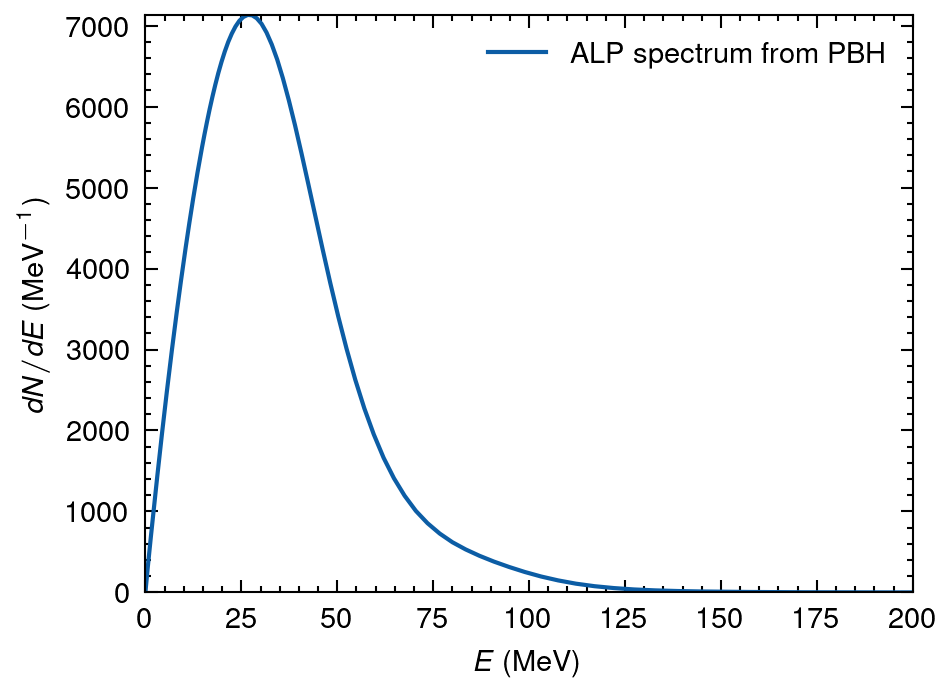

In [6]:
# Plot params
pparam = dict(
    xlabel = r'$E$ (MeV)',
    ylabel = r'$dN/dE$ (MeV$^{-1}$)',
    xscale = 'linear',
    yscale = 'linear',
    xlim = (0, 200),
    # ylim = (0, 1),
)

plt.rcParams['figure.dpi'] = 300

# Plot
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots()
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.plot(E, dNdE_alp, label=r'ALP spectrum from PBH')
    ax.legend()
    # fig.savefig('plot.png', dpi=600, bbox_inches='tight')
    plt.show()

In [7]:
dg = pd.read_parquet("data/emit_total.parquet")
dg.shape

(100000, 1)

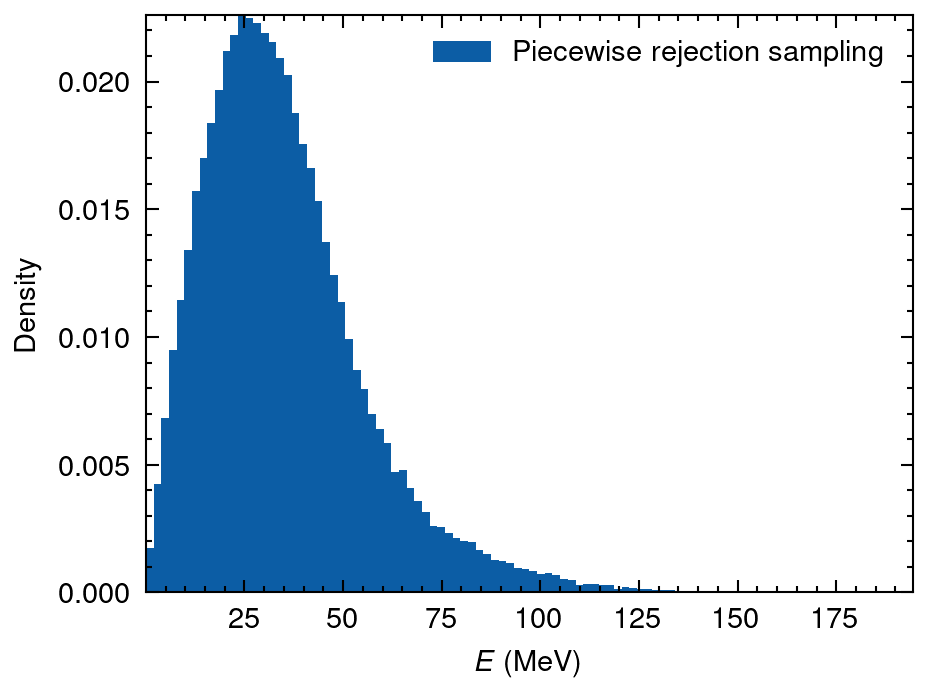

In [8]:
# Plot params
pparam = dict(
    xlabel = r'$E$ (MeV)',
    ylabel = r'Density',
    xscale = 'linear',
    yscale = 'linear',
    # xlim = (0, 200),
    # ylim = (0, 1),
)

# Plot
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots()
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.hist(dg.E, bins=100, density=True, label='Piecewise rejection sampling')
    ax.legend()
    plt.show()

## Normalizing Flow using Pyro

In [9]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))

In [10]:
base_dist

Normal(loc: tensor([0.]), scale: tensor([1.]))

In [11]:
samples = base_dist.sample([10_0000]).numpy()
samples.shape

(100000, 1)

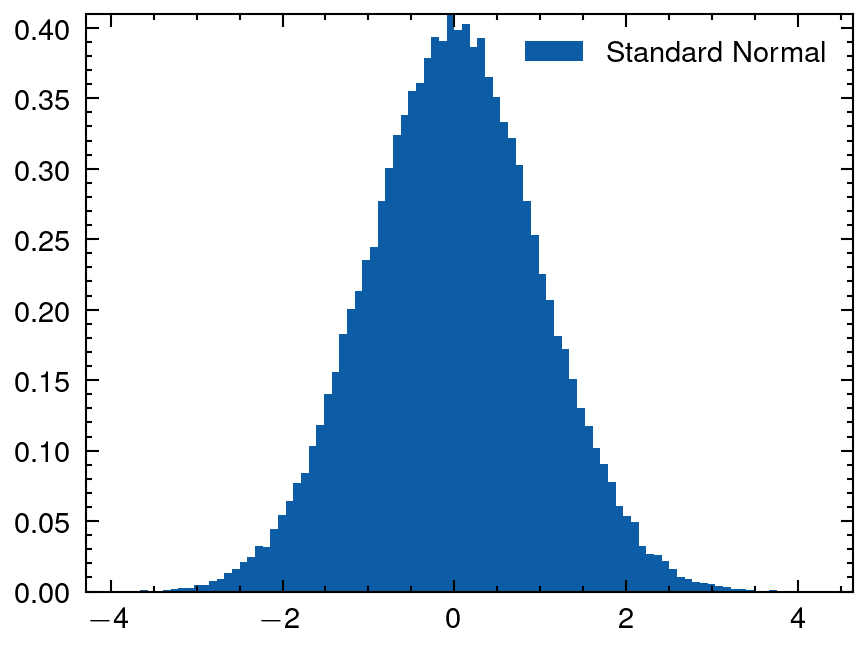

In [12]:
# Plot
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots()
    ax.autoscale(tight=True)
    # ax.set(**pparam)
    ax.hist(samples[:,0], bins=100, density=True, label='Standard Normal')
    ax.legend()
    plt.show()

In [13]:
spline_transform = T.Spline(1, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [14]:
samples_new = flow_dist.sample([10_0000]).numpy()

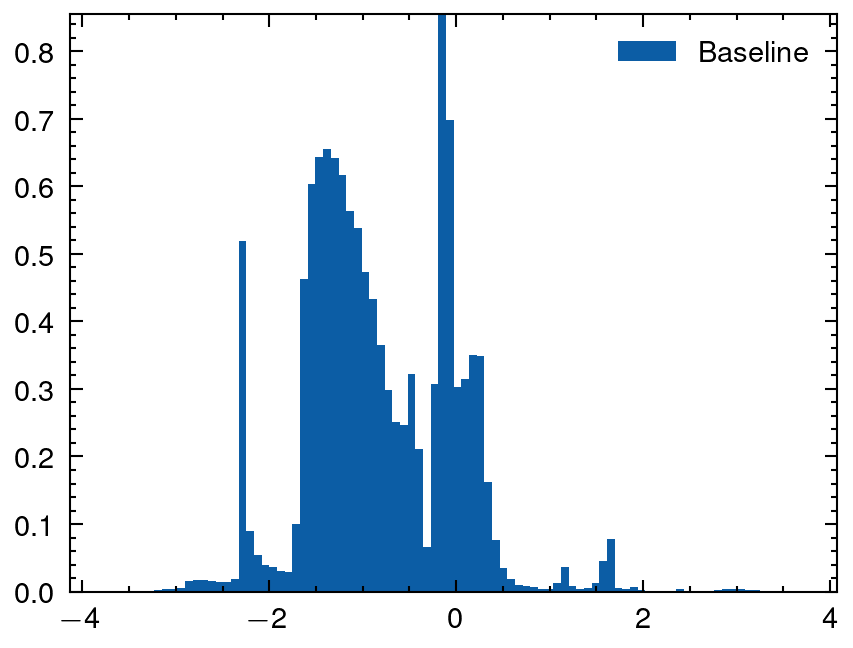

In [15]:
# Plot
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots()
    ax.autoscale(tight=True)
    # ax.set(**pparam)
    ax.hist(samples_new[:,0], bins=100, density=True, label='Baseline')
    ax.legend()
    plt.show()

In [16]:
%%time
steps = 10001
E = dg.E.to_numpy().reshape(-1,1)
sc = StandardScaler()
sc.fit(E)
E = sc.transform(E)
dataset = torch.tensor(E, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print(f'step: {step}, loss: {loss.item()}')

step: 0, loss: 2.1608994007110596
step: 200, loss: 1.34999418258667
step: 400, loss: 1.339239478111267
step: 600, loss: 1.3366087675094604
step: 800, loss: 1.3354387283325195
step: 1000, loss: 1.334762692451477
step: 1200, loss: 1.334364652633667
step: 1400, loss: 1.334068775177002
step: 1600, loss: 1.3338617086410522
step: 1800, loss: 1.3337002992630005
step: 2000, loss: 1.3335778713226318
step: 2200, loss: 1.333478569984436
step: 2400, loss: 1.3333855867385864
step: 2600, loss: 1.3333115577697754
step: 2800, loss: 1.3332468271255493
step: 3000, loss: 1.3331844806671143
step: 3200, loss: 1.3331331014633179
step: 3400, loss: 1.333093285560608
step: 3600, loss: 1.333058476448059
step: 3800, loss: 1.33302903175354
step: 4000, loss: 1.333000659942627
step: 4200, loss: 1.3329771757125854
step: 4400, loss: 1.3329575061798096
step: 4600, loss: 1.3329390287399292
step: 4800, loss: 1.3329229354858398
step: 5000, loss: 1.3329075574874878
step: 5200, loss: 1.3328955173492432
step: 5400, loss: 1.

In [17]:
E_flow = flow_dist.sample(torch.Size([10_0000,])).detach().numpy()

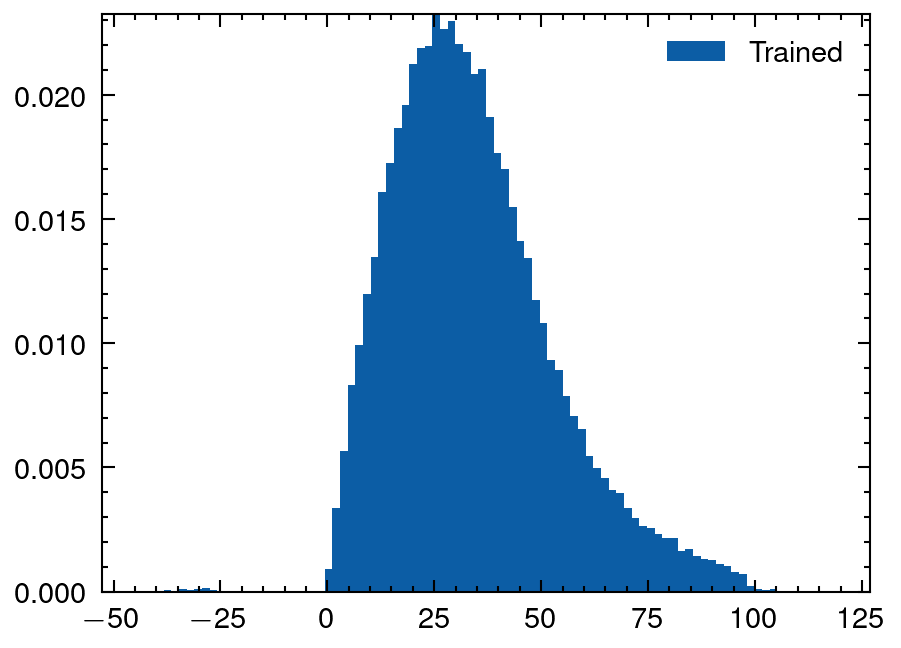

In [18]:
# Plot
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots()
    ax.autoscale(tight=True)
    # ax.set(**pparam)
    ax.hist(sc.inverse_transform(E_flow)[:,0], bins=100, density=True, label='Trained')
    ax.legend()
    plt.show()

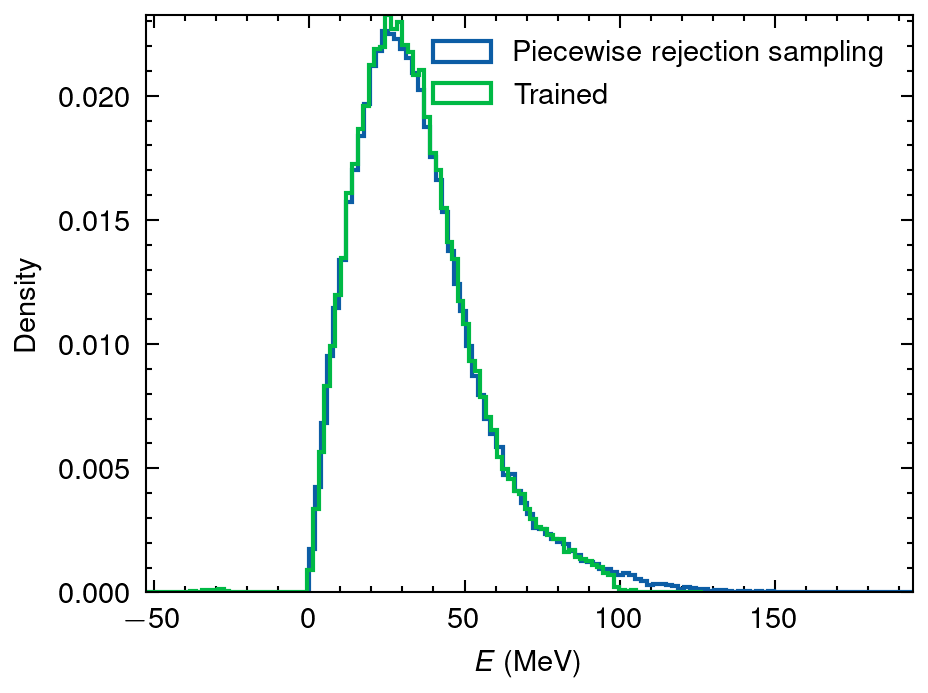

In [19]:
# Plot params
pparam = dict(
    xlabel = r'$E$ (MeV)',
    ylabel = r'Density',
    xscale = 'linear',
    yscale = 'linear',
    # xlim = (0, 200),
    # ylim = (0, 1),
)

# Plot
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots()
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.hist(dg.E, bins=100, density=True, histtype='step', label='Piecewise rejection sampling')
    ax.hist(sc.inverse_transform(E_flow)[:,0], bins=100, histtype='step', density=True, label='Trained')
    ax.legend()
    plt.show()